In [1]:
import tensorflow as tf
import numpy as np
import dataset as ds

trainToTestRatio = 0.8

dataset = np.load('faceFeatures_9216_normalized_labels_as_coord.npz')
samples = dataset['data'].shape[0]
sampleSize = dataset['data'].shape[1]
coordsCount = dataset['y'].shape[1]
splitIdx = int(samples*trainToTestRatio)
trainData = dataset['data'][:splitIdx]
trainY = dataset['y'][:splitIdx]
testData = dataset['data'][splitIdx:]
testY = dataset['y'][splitIdx:]

resultDataset = ds.TestsetDB()

In [2]:
resultData = np.zeros((resultDataset.rows(), sampleSize), np.float32)
for face in resultDataset.getFaces():
    resultData[face.id - 1, :] = face.image.reshape((sampleSize,)).astype(np.float32) / 255.0

def saveResult(resultY):
    for idx in range(resultY.shape[0]):
        face = resultDataset.getFace(idx + 1)
        for featureId in ds.allFeatures:
            x = (resultY[idx, featureId * 2] + 1) * (96 / 2.0)
            y = (resultY[idx, featureId * 2 + 1] + 1) * (96 / 2.0)
            face.setFeaturePosition(featureId, (x, y))
    resultDataset.write()

In [3]:
hiddenLayerSize = 100
outputSize = coordsCount

x = tf.placeholder(tf.float32, shape=[None, sampleSize])
y_ = tf.placeholder(tf.float32, shape=[None, outputSize])

# Hidden

W_hidden = tf.Variable(tf.truncated_normal((sampleSize, hiddenLayerSize), stddev=0.1))
b_hidden = tf.Variable(tf.constant(0.1, shape=(hiddenLayerSize,)))

hidden = tf.nn.relu(tf.matmul(x, W_hidden) + b_hidden)

# Output

W_output = tf.Variable(tf.truncated_normal((hiddenLayerSize, outputSize), stddev=0.1))
b_output = tf.Variable(tf.constant(0.1, shape=(outputSize,)))
y = tf.matmul(hidden, W_output) + b_output

# add overfitting control

# Saver
saver = tf.train.Saver()

In [4]:
#lossFunc = tf.nn.l2_loss(y - y_)
lossFunc = tf.sqrt(tf.reduce_mean((y - y_)**2))

train_step = tf.train.AdamOptimizer(1e-4).minimize(lossFunc)

In [6]:
epohs = 5000


init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

trainLoss = []
testLoss = []

for i in range(epohs):
    evalY=y.eval(feed_dict={x:trainData},session=sess)
    evalY[~np.isnan(trainY)]=trainY[~np.isnan(trainY)]
    if i % 100 == 0:
        train = lossFunc.eval(feed_dict={x:trainData, y_:evalY}, session=sess)
        evalTestY=y.eval(feed_dict={x:testData},session=sess)
        evalTestY[~np.isnan(testY)]=testY[~np.isnan(testY)]
        test = lossFunc.eval(feed_dict={x:testData, y_:evalTestY}, session=sess)
        
        print('train:', train, 'test:', test)
    train_step.run(feed_dict={x:trainData, y_:evalY}, session=sess)

train: 3.07586 test: 3.00489
train: 0.281572 test: 0.339924
train: 0.19915 test: 0.272062
train: 0.159074 test: 0.231592
train: 0.132529 test: 0.20553
train: 0.118538 test: 0.191146
train: 0.105451 test: 0.176185
train: 0.0949882 test: 0.16536
train: 0.0881249 test: 0.15821
train: 0.0837867 test: 0.154545
train: 0.0801257 test: 0.15137
train: 0.0768165 test: 0.148551
train: 0.0736366 test: 0.145827
train: 0.0703815 test: 0.143071
train: 0.0673198 test: 0.140515
train: 0.0646874 test: 0.138314
train: 0.062457 test: 0.136399
train: 0.0605577 test: 0.134626
train: 0.058933 test: 0.133143
train: 0.05751 test: 0.131757
train: 0.0562525 test: 0.130457
train: 0.0551208 test: 0.129294
train: 0.054175 test: 0.128328
train: 0.0532003 test: 0.126967
train: 0.0523925 test: 0.126325
train: 0.051606 test: 0.125006
train: 0.0507662 test: 0.124225
train: 0.0501056 test: 0.123538
train: 0.0493898 test: 0.122558
train: 0.0487564 test: 0.121779
train: 0.0482571 test: 0.120681
train: 0.0475744 test: 0.120

In [5]:
#save_path = saver.save(sess, "mlp_h100_5000.ckpt")
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
saver.restore(sess, "mlp_h100_5000.ckpt")

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def addFeatures(ax, features, isFill = True):
    for i in range(0, 30, 2):
        x = (features[i] + 1) * (96 / 2.0)
        y = (features[i + 1] + 1) * (96 / 2.0)
        ax.add_patch(patches.Circle((x,y),1, fill = isFill))
    
def showFace(data, features, expectedFeatures = None):
    fig,ax = plt.subplots()
    addFeatures(ax, features)
    if not expectedFeatures is None:
        addFeatures(ax, expectedFeatures, False)
    plt.imshow(data.reshape(96, 96), cmap = 'gray')

In [7]:
evalTrain=y.eval(feed_dict={x:trainData},session=sess)
showTrain = lambda idx : showFace(trainData[idx], evalTrain[idx], trainY[idx])

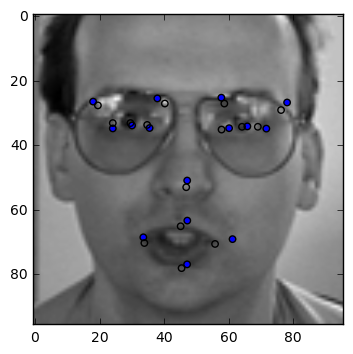

In [9]:
showTrain(7)

In [6]:
evalResult=y.eval(feed_dict={x:resultData}, session=sess)
showResult = lambda idx : showFace(resultData[idx], evalResult[idx])

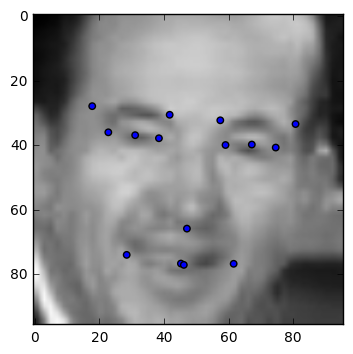

In [9]:
showResult(1780)

In [13]:
saveResult(evalResult)

In [12]:
evalResult[evalResult < -1.0] = -1.0
evalResult[evalResult > 1.0] = 1.0

In [ ]:
def showFace(face):
    fig,ax = plt.subplots()
    for key, value in face.features.items():
        ax.add_patch(patches.Circle(value,1))
    ax.imshow(face.image, cmap = 'gray')

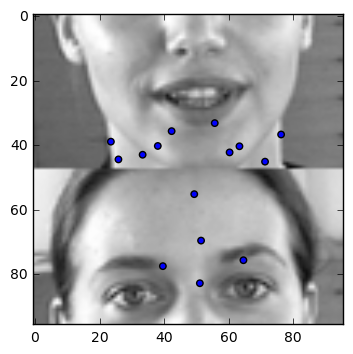

In [43]:
reflected = trainData[20, :].copy()
reflected[:96*48] = trainData[20,96*48:]
reflected[96*48:] = trainData[20,:96*48]

reflected = reflected.reshape((1, -1))

reflectedFeatures = y.eval(feed_dict={x:reflected}, session=sess)[0]
showFace(reflected, reflectedFeatures)

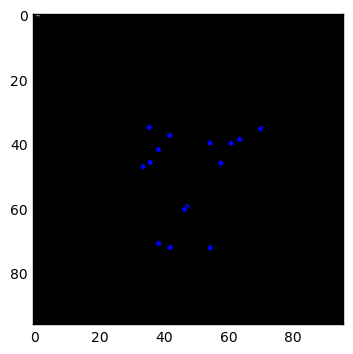

In [51]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

black = np.ones((96*96,))
black = reflected.reshape((1, -1))

def evalBlack(k):
    black = np.ones((96*96,)) * k * (1/100.0)
    black = black.reshape((1, -1))
    black[0, 0] = 0.0
    black[0, 1] = 0.5
    blackFeatures = y.eval(feed_dict={x:black}, session=sess)[0]
    showFace(black, blackFeatures)

interact(evalBlack, k=widgets.IntSlider(min=0,max=100,step=1,value=0))